In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder.appName('316_Group')\
        .config("spark-master", "local")\
        .getOrCreate()

#Files' directory
directory = 'original file/Unzipped/donation/data/'

In [2]:
"""
Merging block
"""
#Load all the files in the folder.

data= spark \
.read \
.format("csv") \
.option("header","true")\
.option("inferSchema", "true")\
.option("nullValue","?")\
.load(directory)

#To see the quantity of columns and data
print("Column: " + str(len(data.schema)))#Column: 12, which is correct.
print("Data: " + str(data.count()))#Data: 5749132, which is correct.


Column: 12
Data: 5749132


In [3]:
"""
Data Analysis
"""
#To see the DataFrame's columns' type
data.printSchema()

root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: double (nullable = true)
 |-- cmp_fname_c2: double (nullable = true)
 |-- cmp_lname_c1: double (nullable = true)
 |-- cmp_lname_c2: double (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: integer (nullable = true)
 |-- cmp_bm: integer (nullable = true)
 |-- cmp_by: integer (nullable = true)
 |-- cmp_plz: integer (nullable = true)
 |-- is_match: boolean (nullable = true)



In [4]:
#show columns' null value quantity
print("Missing Attribute Values:")
print("cmp_fname_c1: "+str(data.where(col("cmp_fname_c1").isNull()).count()))
print("cmp_fname_c2: "+str(data.where(col("cmp_fname_c2").isNull()).count()))
print("cmp_lname_c1: "+str(data.where(col("cmp_lname_c1").isNull()).count()))
print("cmp_lname_c2: "+str(data.where(col("cmp_lname_c2").isNull()).count()))
print("cmp_sex: "+str(data.where(col("cmp_sex").isNull()).count()))
print("cmp_bd: "+str(data.where(col("cmp_bd").isNull()).count()))
print("cmp_bm: "+str(data.where(col("cmp_bm").isNull()).count()))
print("cmp_by: "+str(data.where(col("cmp_by").isNull()).count()))
print("cmp_plz: "+str(data.where(col("cmp_plz").isNull()).count()))
print("is_match: "+str(data.where(col("is_match").isNull()).count()))

"""
"cmp_fname_c2" column and "cmp_lname_c2" column have too many null values 
which take a significantly high percentage of the data in their columns.

The meaning of the "cmp_fname_c2" column and "cmp_lname_c2" column is that 
"agreement of first name, second component" and "agreement of last name, second component".

In my view, it might mean that people don't like filling the field for the second component, 
so I will not use these two columns as predictive attributes.
"""

Missing Attribute Values:
cmp_fname_c1: 1007
cmp_fname_c2: 5645434
cmp_lname_c1: 0
cmp_lname_c2: 5746668
cmp_sex: 0
cmp_bd: 795
cmp_bm: 795
cmp_by: 795
cmp_plz: 12843
is_match: 0


'\n"cmp_fname_c2" column and "cmp_lname_c2" column have too many null values \nwhich take a significantly high percentage of the data in their columns.\n\nThe meaning of the "cmp_fname_c2" column and "cmp_lname_c2" column is that \n"agreement of first name, second component" and "agreement of last name, second component".\n\nIn my view, it might mean that people don\'t like filling the field for the second component, \nso I will not use these two columns as predictive attributes.\n'

In [5]:
#remove the columns of "cmp_fname_c2", "cmp_lname_c2", "id_1", and "id_2"
#"cmp_fname_c2" and "cmp_lname_c2" have too many null data
data_new = data.drop("cmp_fname_c2", "cmp_lname_c2","id_1","id_2")

total_null = data_new.where(col("cmp_fname_c1")\
               .isNull()|col("cmp_bd")\
               .isNull()|col("cmp_bm")\
               .isNull()|col("cmp_by")\
               .isNull()|col("cmp_plz")\
               .isNull()).count()

print("Percentagies of totoal null value: "+str((total_null/5749132)*100) + "%")
#They only take 0.25471671201844037% which is much smaller than 5%, 
#so we can eliminate objects with missing values

Percentagies of totoal null value: 0.25471671201844037%


In [6]:
#Renew the data which don't have a null value.
data_new = data_new.where(col("cmp_fname_c1")\
               .isNotNull()&col("cmp_bd")\
               .isNotNull()&col("cmp_bm")\
               .isNotNull()&col("cmp_by")\
               .isNotNull()&col("cmp_plz")\
               .isNotNull())

In [7]:
#Use describe() to compute the basic statistics for columns except "id_1" and "id_2" columns
data_new.describe().show()
#count, mean, standard deviation, min and max


+-------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|summary|      cmp_fname_c1|       cmp_lname_c1|            cmp_sex|             cmp_bd|             cmp_bm|             cmp_by|             cmp_plz|
+-------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|  count|           5734488|            5734488|            5734488|            5734488|            5734488|            5734488|             5734488|
|   mean|0.7128378763439656|0.31565622641400654|  0.955898591120951|0.22440294582532913|0.48879481481171466|0.22266033166343707|0.005528305229690951|
| stddev|0.3887937288745518| 0.3342432492920115|0.20532043728115867| 0.4171885593841717| 0.4998744716415133|  0.416032136438687| 0.07414677356226697|
|    min|               0.0|                0.0|                  0|                  0|            

In [8]:
"""
There is the explaination of the data in the documentation file:

The agreement of name components is measured as a real number in the interval [0,1], 
where 0 denotes maximal disagreement and 1 equality of the underlying values. 

For the other comparisons, only the values 0 (not equal) and 1 (equal) are used.
"""

#Quantiles and Percentiles
quantileProbs = [0.025, 0.25, 0.5, 0.75, 0.975]
relError = 0.05 # may be expensive if set to 0
print("Quantiles and Percentiles for cmp_fname_c1 and cmp_lname_c1:")
data_new.stat.approxQuantile(["cmp_fname_c1","cmp_lname_c1","cmp_sex","cmp_bd","cmp_bm","cmp_by","cmp_plz"],quantileProbs, relError)

Quantiles and Percentiles for cmp_fname_c1 and cmp_lname_c1:


[[0.0, 0.375, 1.0, 1.0, 1.0],
 [0.0, 0.111111111111111, 0.2, 0.6, 1.0],
 [0.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0]]

In [9]:
import matplotlib.pyplot as plt
Bar_cmp_fname_c1 = data_new.groupBy("cmp_fname_c1").agg(count("cmp_fname_c1"))
CF_x = Bar_cmp_fname_c1.select("cmp_fname_c1").toPandas().values
CF_y = Bar_cmp_fname_c1.select("count(cmp_fname_c1)").toPandas().values

CF_x= CF_x.flatten()
CF_y= CF_y.flatten()

plt.bar(CF_x, CF_y, align =  'center') 
plt.title('Bar graph for "cmp_fname_c1" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

<Figure size 640x480 with 1 Axes>

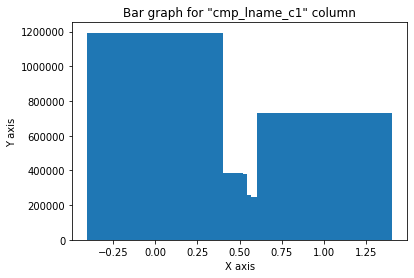

In [10]:
Bar_cmp_lname_c1 = data_new.groupBy("cmp_lname_c1").agg(count("cmp_lname_c1"))
CL_x = Bar_cmp_lname_c1.select("cmp_lname_c1").toPandas().values
CL_y = Bar_cmp_lname_c1.select("count(cmp_lname_c1)").toPandas().values

CL_x= CL_x.flatten()
CL_y= CL_y.flatten()

plt.bar(CL_x, CL_y, align =  'center') 
plt.title('Bar graph for "cmp_lname_c1" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

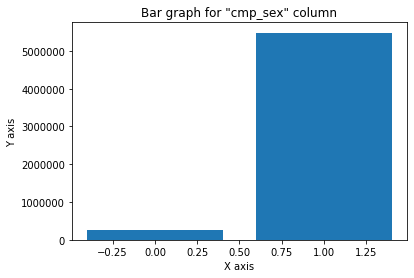

In [11]:
Bar_cmp_sex = data_new.groupBy("cmp_sex").agg(count("cmp_sex"))
CS_x = Bar_cmp_sex.select("cmp_sex").toPandas().values
CS_y = Bar_cmp_sex.select("count(cmp_sex)").toPandas().values

CS_x= CS_x.flatten()
CS_y= CS_y.flatten()

plt.bar(CS_x, CS_y, align =  'center') 
plt.title('Bar graph for "cmp_sex" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

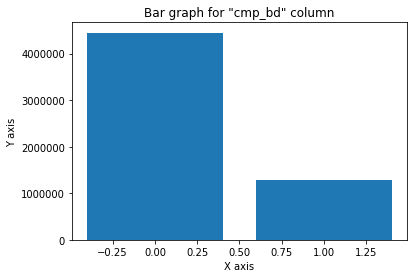

In [12]:
Bar_cmp_bd = data_new.groupBy("cmp_bd").agg(count("cmp_bd"))
CBD_x = Bar_cmp_bd.select("cmp_bd").toPandas().values
CBD_y = Bar_cmp_bd.select("count(cmp_bd)").toPandas().values

CBD_x= CBD_x.flatten()
CBD_y= CBD_y.flatten()

plt.bar(CBD_x, CBD_y, align =  'center') 
plt.title('Bar graph for "cmp_bd" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

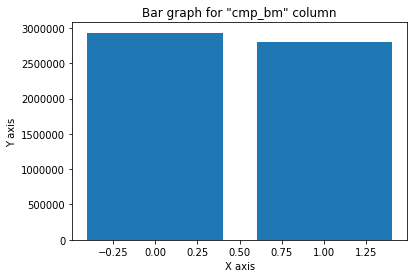

In [13]:
Bar_cmp_bm = data_new.groupBy("cmp_bm").agg(count("cmp_bm"))
CBM_x = Bar_cmp_bm.select("cmp_bm").toPandas().values
CBM_y = Bar_cmp_bm.select("count(cmp_bm)").toPandas().values

CBM_x= CBM_x.flatten()
CBM_y= CBM_y.flatten()

plt.bar(CBM_x, CBM_y, align =  'center') 
plt.title('Bar graph for "cmp_bm" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

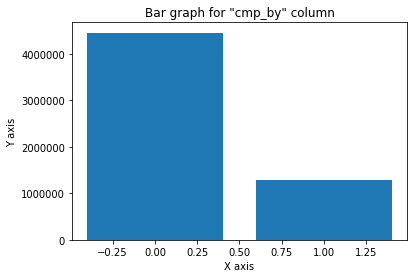

In [14]:
Bar_cmp_by = data_new.groupBy("cmp_by").agg(count("cmp_by"))
CBY_x = Bar_cmp_by.select("cmp_by").toPandas().values
CBY_y = Bar_cmp_by.select("count(cmp_by)").toPandas().values

CBY_x= CBY_x.flatten()
CBY_y= CBY_y.flatten()

plt.bar(CBY_x, CBY_y, align =  'center') 
plt.title('Bar graph for "cmp_by" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

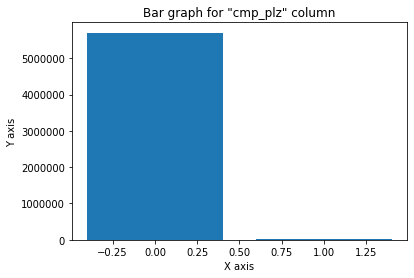

In [15]:
Bar_cmp_plz = data_new.groupBy("cmp_plz").agg(count("cmp_plz"))
CMP_x = Bar_cmp_plz.select("cmp_plz").toPandas().values
CMP_y = Bar_cmp_plz.select("count(cmp_plz)").toPandas().values

CMP_x= CMP_x.flatten()
CMP_y= CMP_y.flatten()

plt.bar(CMP_x, CMP_y, align =  'center') 
plt.title('Bar graph for "cmp_plz" column') 
plt.ylabel('Y axis') 
plt.xlabel('X axis') 
plt.show()

In [16]:
#Shuffle the data and split it into training set and test set.
test_set,train_set = data_new.randomSplit([0.3, 0.7], data_new.count())
#split training set into attributes and classes
test_attributes = test_set.drop("is_match")
test_classes = test_set.select("is_match")
#split test set into attributes and classes
train_attributes = train_set.drop("is_match")
train_classes = train_set.select("is_match")

In [17]:
#Convert them into numpy array.
test_attributes = test_attributes.toPandas().values
train_attributes = train_attributes.toPandas().values
test_classes = test_classes.toPandas().values
train_classes = train_classes.toPandas().values

In [29]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,regularizers

e_records,_ = train_attributes.shape
n_neurons_h = 30 #hidden layer nurons
n_neurons_out = 1 #we only has one 
n_epochs = 5 #iterations
learning_rate = 0.1
_,n_records = train_attributes.shape

DNN =Sequential()
#Input dimension should be same with the number of attributes
DNN.add(Dense(7, input_dim=7))

# tanh is a very practical activation function for the hidden layers,
#use Regularisation to advoid overfitting
DNN.add(Dense(n_neurons_h,activation='tanh',kernel_regularizer=regularizers.l1(0.01)))
DNN.add(Dense(int(n_neurons_h/2),activation='tanh',kernel_regularizer=regularizers.l1(0.01)))

#it is binary classification so we use logistic function which is sigmoid for the output layer, 
#use Regularisation to advoid overfitting
DNN.add(Dense(n_neurons_out,activation='sigmoid',kernel_regularizer=regularizers.l1(0.01)))
#MLP.add(Dense(n_neurons_out,activation='sigmoid'))

DNN.summary()

#Batch Gradient Descent Optimizer and binary_crossentropy for loss
DNN.compile(loss='binary_crossentropy',optimizer=tf.train.GradientDescentOptimizer(learning_rate),
            metrics=['acc','mae'])

"""
Advantages: global optimal solution; easy to implement in parallel;
Disadvantages: When the number of samples is large, the training process will be slow.
"""
history=DNN.fit(train_attributes,train_classes,batch_size = int(e_records/10),epochs=n_epochs)

score = DNN.evaluate(test_attributes,test_classes)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_10 (Dense)             (None, 30)                240       
_________________________________________________________________
dense_11 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 16        
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4012191/4012191 [==============================] - 3s 1us/step - loss: 1.7752 - acc: 0.9249 - mean_absolute_error: 0.3985
Epoch 2/5
4012191/4012191 [==============================] - 1s 0us/step - loss: 1.6303 - acc: 0.9697 - mean_absolute_error: 0.3088
Epoch 3/5
40

KeyboardInterrupt: 

In [31]:
#RNN takes large computation and memory.

from tensorflow import keras

n_neurons_h = 30
n_neurons_out = 1
learning_rate = 0.1
n_epochs = 5
e_records,_ = train_attributes.shape

RNN = tf.keras.Sequential()

#Use Embedding layer to put the data to model
RNN.add(keras.layers.Embedding(input_dim=7, output_dim=7))
# Add a RNN layer with 30 internal units.
RNN.add(keras.layers.SimpleRNN(n_neurons_h))

# Add a Dense layer with 1 units and sigmoid activation.
RNN.add(keras.layers.Dense(n_neurons_out, activation='sigmoid'))

RNN.summary()

RNN.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy','mae'])

RNN.fit(train_attributes,train_classes,batch_size = int(e_records/10),epochs = n_epochs)



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 7)           49        
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 30)                1140      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4012191/4012191 [==============================] - 2s 1us/sample - loss: 0.2565 - acc: 0.9852 - mean_absolute_error: 0.2099
Epoch 2/5
4012191/4012191 [==============================] - 2s 1us/sample - loss: 0.0435 - acc: 0.9963 - mean_absolute_error: 0.0351
Epoch 3/5
4012191/4012191 [==============================] - 2s 1us/sample - loss: 0.0311 - acc: 0.9963 - mean_ab

In [41]:
from keras.models import Sequential
from keras.layers import Dense ,Conv1D, Flatten, MaxPooling1D

#CNN takes largest computation and memory.

n_neurons_input = 7
n_neurons_out = 1
learning_rate = 0.1
n_epochs = 5
e_records,_ = train_attributes.shape

#Expand training set's dimension to be able to put it into the model
train_attributes_expand = tf.expand_dims(train_attributes, 2)

#create model
CNN = Sequential()
#Convolutional Layer
CNN.add(Conv1D(n_neurons_input, kernel_size=1, activation='tanh', input_shape=(7,1)))
#shunk the data.
CNN.add(MaxPooling1D(pool_size=2, strides=None, padding='same', data_format='channels_last'))
#Flatten layer
CNN.add(Flatten())
#Output layer
CNN.add(Dense(n_neurons_out, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy','mae'])

CNN.fit(train_attributes_expand,train_classes,epochs = n_epochs,steps_per_epoch = 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 7, 7)              14        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 4, 7)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 29        
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5/5 [==============================] - 40s 8s/step - loss: 0.7723 - acc: 0.4013 - mean_absolute_error: 0.5323
Epoch 2/5
5/5 [==============================] - 16s 3s/step - loss: 0.4361 - acc: 0.9908 - mean_absolute_error: 0.3512
Epoch 3/5
5/5 [=======================